# Spotify Playlist Prediction
**Kevin Yoon, Madeleine Nakada, Michelle Xie**

*Something here about what we're doing*

## Import Libraries

In [1]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import requests
import pprint
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import csv
# import sklearn.linear_model

In [2]:
pp = pprint.PrettyPrinter(indent=4)

In [3]:
#from spotify import get_features

In [4]:
import config
import base64

## Building the Data Set

We need to get additional information from Spotify since playlists only give us basic information like song title and artist. We make calls to 3 APIs for each song, which is slow so we've stored the information we need about songs we've already seen.

In [63]:
def get_token():
    cred = config.api_key
    byte =  cred.encode("utf-8")
    # b64Val = base64.b64encode(byte)
    b64 = base64.urlsafe_b64encode(cred.encode()).decode()
    auth = {'Authorization': 'Basic ' + b64}
    payload = {"grant_type": "client_credentials"}
    response = requests.post("https://accounts.spotify.com/api/token", 
        data=payload, headers=auth)
    return response.json()['access_token']
token = get_token()

base_url = "https://api.spotify.com/v1"
headers = {'Authorization': 'Bearer ' + token}


In [6]:
def get_features(songs):
    url = base_url + '/audio-features'
    i = 0
    features = []
    while i < len(songs):
        current = songs[i:i+100]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        features = features + data["audio_features"]
        i = i + 100
    return features

In [7]:
def get_genres(artists):
    genres = Counter()
    url = base_url + '/artists'
    i = 0
    genre_list = []
    while i < len(artists):
        current = artists[i:i+10]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for artist in data['artists']:
            for genre in artist['genres']:
                genres[genre] += 1
            genre_list.append(artist['genres'])
        i = i + 10
    return genres, genre_list

In [8]:
def get_years(albums):
    years = Counter()
    years_list = []
    url = base_url + '/albums'
    i = 0
    while i < len(albums):
        current = albums[i:i+20]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for album in data['albums']:
            date = album['release_date']
            year = date.split('-')[0]
            years[year] += 1
            years_list.append(year)
        i = i + 20
    return years, years_list

In [9]:
def get_popularity(songs):
    popularity = []
    url = base_url + '/tracks'
    i = 0
    while i < len(songs):
        current = songs[i:i+50]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for track in data['tracks']:
            popularity.append(track['popularity'])
        i = i + 50
    return popularity

In [10]:
feature_data = {}
genre_data = {}
year_data = {}
popularity_data = {}

In [11]:
def get_new_songs(genre, year):
    genre = "%22" + genre.replace(' ', '%20') + "%22"
    url = base_url + '/search?limit=50&type=track&q=genre:' + genre + "%20year:"+str(year) + "%20year:"+str(year + 1)+ "%20year:"+str(year + -1)
    r =requests.get(url, headers=headers)
    data =  r.json()
    ids = []
    songs = []
    artists = set([])
    albums = set([])
    for track in data['tracks']["items"]:
        ids.append(track["id"])
        if not track["id"] in feature_data:
            songs.append(track["id"])
            albums.add(track["album"]["id"])
            artists.add(track["artists"][0]["id"])
    song_features = get_features(songs)
    genres, genre_list = get_genres(list(artists))
    years, years_list = get_years(list(albums))
    popularity = get_popularity(songs)
    popularity_list = list(popularity)

    # add new songs to our database
    for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
        feature_data[song] = feature
        genre_data[song] = genre
        year_data[song] = year
        popularity_data[song] = pop
    return ids

In [12]:
print(get_new_songs('pop', 2018))

['2rPE9A1vEgShuZxxzR2tZH', '2xLMifQCjDGFmkHkpNLD9h', '7l3E7lcozEodtVsSTCkcaA', '5p7ujcrUXASCNwRaWNHR1C', '1A6OTy97kk0mMdm78rHsm8', '1xzBco0xcoJEDXktl7Jxrr', '2dpaYNEQHiRxtZbfNsse99', '1BxkZE73h9BN3qwuA15TA3', '7dt6x5M1jzdTEt8oCbisTK', '0QIjsbm2fh1cJ45XO9eGqq', '4w8niZpiMy6qz1mntFA5uM', '0d2iYfpKoM0QCKvcLCkBao', '2IRZnDFmlqMuOrYOLnZZyc', '6zeeWid2sgw4lap2jV61PZ', '5IaHrVsrferBYDm0bDyABy', '4OafepJy2teCjYJbvFE60J', '5274I4mUMnYczyeXkGDWZN', '6wWaVoUOzLQJHd3bWAUpdZ', '6vN77lE9LK6HP2DewaN6HZ', '4S8d14HvHb70ImctNgVzQQ', '58q2HKrzhC3ozto2nDdN4z', '5OCJzvD7sykQEKHH7qAC3C', '3swc6WTsr7rl9DqQKQA55C', '0e7ipj03S05BNilyu5bRzt', '7wC5eZcFS1Q1BsQ35DU6H4', '0u695M7KyzXaPIjpEbxOkB', '7wBJfHzpfI3032CSD7CE2m', '7lAK3oHbfEnvUQWosrMMpR', '5SCE6bkrXysjBSShvhOkAa', '2qT1uLXPVPzGgFOx4jtEuo', '6DCZcSspjsKoFjzjrWoCdn', '2G7V7zsVDxg1yRsu7Ew9RJ', '4VUwkH455At9kENOfzTqmF', '1rqqCSm0Qe4I9rUvWncaom', '04MLEeAMuV9IlHEsD8vF6A', '0Fpen1PTuEnCmOJtUU9Iud', '5qHirGR7M9tdm6C17DlzSY', '0ZNrc4kNeQYD9koZ3KvCsy', '5tAa8Uaqr4

Create a progress bar function since getting the data can be slow and we want to make sure the program is still running. Also tracks number of failures for getting features which later we could troubleshoot but for now we're avoiding.

In [13]:
def progress_bar(index, total, failures):
    clear_output(wait=True)
    percent = index/total
    bars = "#" * int(percent * 30)
    lines = "-" * int((1-percent) * 30)
    display("|" + bars + lines + "| (%d/%d) with %d failures"%(index,total, failures))

Randomly select a set of 1000 playlists from the Million Playlist Dataset (this is easier than actually selecting 1000 playlists individually from such a massive data set) and extract the playlist information.

In [14]:
index = random.randint(0,1000) * 1000
print(index)

849000


In [15]:
path = './data/mpd.slice.'+ str(index)+'-'+ str(index + 999) + '.json'

with open(path) as infile:
    data = json.load(infile)
playlists = pd.DataFrame(data['playlists'])
playlists.set_index("pid")
playlists.shape

(1000, 12)

Add columns for our features which we get using the **get_features** function

In [16]:
feature_names = ["acousticness", "danceability","duration_ms",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "year", "popularity","genre"]
for feature in feature_names:
    playlists[feature] = None

In [17]:
playlists.head()

collaborative description duration_ms  modified_at               name  \
0         false         NaN        None   1488672000              Naomi   
1         false         NaN        None   1373414400               Naps   
2         false         NaN        None   1421366400         highschool   
3         false         NaN        None   1453680000  christmas carols!   
4         false         NaN        None   1502064000      driving songs   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          96           68          3              1         106  ...    
1          15           14          5              2          17  ...    
2          52           42          8              2          71  ...    
3          17           16          6              2          22  ...    
4          60           42         24              1          83  ...    

   liveness loudness  mode speechiness time_signature tempo valence  year  \
0      None     None  None        None           None  None    None  None   
1      None     None  None        None           None  None    None  None   
2      None     None  None        None           None  None    None  None   
3      None     None  None        None           None  None    None  None   
4      None     None  None        None           None  None    None  None   

  popularity genre  
0       None  None  
1       None  None  
2       None  None  
3       None  None  
4       None  None  

[5 rows x 27 columns]

Get the features for each playlist (with our progress bar!)

In [18]:
with open('./songs/feature_data.txt', 'r') as infile:
    feature_data = eval(infile.read())
with open('./songs/genre_data.txt', 'r') as infile:
    genre_data = eval(infile.read())
with open('./songs/year_data.txt', 'r') as infile:
    year_data = eval(infile.read())
with open('./songs/popularity_data.txt', 'r') as infile:
    popularity_data = eval(infile.read())


In [19]:
len(feature_data)

45731

In [20]:
failures = 0
# iterate over all playlists
for index, row in playlists.iterrows():
    # render progress bar
    progress_bar(index + 1,playlists.shape[0], failures)
    # initialize all values to 0
    features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
    artists = set({})
    albums = set({})
    
#     artists = Counter()
#     counters = set(["artists"])
    all_features = set(features.keys())

    # get tracks for playlist
    tracks = row["tracks"]

    # seen stores the songs we've seen, songs stores new songs
    seen = []
    songs = []
    # iterate over all songs in playlist
    for track in tracks:
        track_id = track['track_uri'].split(":")[-1]
        
        # if we've seen the track, continue, otherwise get its identifiers
        if track_id in feature_data:
            seen.append(track_id)
        else:
            songs.append(track_id)
            artist_id = track['artist_uri'].split(":")[-1]
            artists.add(artist_id)
            album_id = track['album_uri'].split(":")[-1]
            albums.add(album_id)
    # get song data, either by looking up on API or in our files
    # if there's any issue with the failure we skip this row rather than
    # terminating the program
    try:
        # get information for new songs, returning counters and raw list
        song_features = get_features(songs)
        genres, genre_list = get_genres(list(artists))
        years, years_list = get_years(list(albums))
        popularity = get_popularity(songs)
        popularity_list = list(popularity)
        
        # add new songs to our database
        for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
            feature_data[song] = feature
            genre_data[song] = genre
            year_data[song] = year
            popularity_data[song] = pop
        # add data from our seen songs
        for song in seen:
            song_features.append(feature_data[song])
#             temp = ''
#             for genre in genre_data[song]:
#                 if len(genre) == 1:
#                     print(genre)
            if type(genre_data[song]) == list:
                for genre in genre_data[song]:
                    genres[genre] += 1
            else:
#                 print(genre_data[song])
                genres[genre_data[song]] += 1
            popularity.append(popularity_data[song])
            years[year_data[song]] += 1
            
        # update popularity to be median value (not mean b/c outliers)
        popularity = np.median(popularity)
        features['popularity'] = popularity        

        # insert all information into features dict
        for song in song_features:
            for feature in all_features:

                features[feature] += song[feature]
        # average necessary values and update data table
        for feature in feature_names:
            if feature in all_features:
                features[feature] = features[feature] / len(tracks)
                if feature == "time_signature":
                    features[feature] = int(features[feature] + 0.5)
            elif feature == "year":
                features["year"] = int(years.most_common(1)[0][0])
            elif feature == "genre":
                features["genre"] = genres.most_common(1)[0][0]            
            playlists.at[index, feature] = features[feature]
    except Exception as ex:
        print(ex)
        failures += 1



'|##############################| (1000/1000) with 3 failures'

In [26]:
# dicts= [feature_data, genre_data, year_data,popularity_data]

with open('./songs/feature_data.txt', 'w') as file:
    file.write(str(feature_data))
with open('./songs/genre_data.txt', 'w') as file:
    file.write(str(genre_data))
with open('./songs/year_data.txt', 'w') as file:
    file.write(str(year_data))
with open('./songs/popularity_data.txt', 'w') as file:
    file.write(str(popularity_data))

In [27]:

playlists.head()

collaborative description    duration_ms  modified_at               name  \
0         false         NaN  128479.926943   1488672000              Naomi   
1         false         NaN  183530.400301   1373414400               Naps   
2         false         NaN  195921.695193   1421366400         highschool   
3         false         NaN  115349.730949   1453680000  christmas carols!   
4         false         NaN  193381.276776   1502064000      driving songs   

   num_albums  num_artists  num_edits  num_followers  num_tracks  \
0          96           68          3              1         106   
1          15           14          5              2          17   
2          52           42          8              2          71   
3          17           16          6              2          22   
4          60           42         24              1          83   

       ...        liveness   loudness      mode  speechiness  time_signature  \
0      ...        0.117738  37.424486  0.399807     0.117607             2.0   
1      ...        0.197397  -3.456537  0.383181     0.159262             4.0   
2      ...        0.213529  -0.722286  0.594565     0.097947             3.0   
3      ...        0.104931  16.508943  0.474513     0.047180             2.0   
4      ...        0.124545   3.827199  0.653007     0.064381             3.0   

        tempo   valence  year  popularity          genre  
0   65.344888  0.282636  2015        60.5     trap music  
1   96.655654  0.455711  2006          32            rap  
2  119.283462  0.381361  2006          40       pop punk  
3   69.349708  0.320163  2012          60  post-teen pop  
4   94.599828  0.277426  2015          45            pop  

[5 rows x 27 columns]

In [28]:
features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
for feature in list(features.keys()):
    playlists[feature] = pd.to_numeric(playlists[feature])

playlists[list(features.keys())].describe()

acousticness  danceability    duration_ms      energy  \
count    997.000000    997.000000     997.000000  997.000000   
mean       0.211714      0.413359  164734.329806    0.452791   
std        0.131620      0.085127   47005.118735    0.112794   
min        0.000698      0.152970   69122.581106    0.086119   
25%        0.130860      0.360006  133778.859761    0.382312   
50%        0.172619      0.398030  154109.787308    0.436228   
75%        0.250148      0.454084  184820.213101    0.511193   
max        0.976198      0.735656  469166.538119    0.950272   

       instrumentalness         key    liveness    loudness        mode  \
count        997.000000  997.000000  997.000000  997.000000  997.000000   
mean           0.088971    3.836982    0.143425   11.060170    0.488808   
std            0.119193    0.804038    0.046850   16.235694    0.128847   
min            0.000003    2.142743    0.058937  -25.350034    0.190500   
25%            0.036158    3.247132    0.115879    0.436448    0.399245   
50%            0.055051    3.725287    0.135799    7.566253    0.467430   
75%            0.088670    4.332435    0.159984   17.377848    0.558145   
max            0.911193    7.833333    0.803400  114.754884    0.952381   

       speechiness  time_signature       tempo     valence  
count   997.000000      997.000000  997.000000  997.000000  
mean      0.074675        2.651956   83.578598    0.349790  
std       0.042821        0.687108   18.174371    0.100756  
min       0.029518        1.000000   37.314672    0.063362  
25%       0.051193        2.000000   69.943354    0.284415  
50%       0.063554        3.000000   81.428747    0.330880  
75%       0.086170        3.000000   94.964537    0.392047  
max       0.895200        4.000000  160.402102    0.845152

## Clean Up Data
Remove entries for which we couldn't get all song data

In [29]:
clean_data = playlists[playlists["time_signature"] > 0]
print(clean_data.shape)
clean_data.head()

(997, 27)


collaborative description    duration_ms  modified_at               name  \
0         false         NaN  128479.926943   1488672000              Naomi   
1         false         NaN  183530.400301   1373414400               Naps   
2         false         NaN  195921.695193   1421366400         highschool   
3         false         NaN  115349.730949   1453680000  christmas carols!   
4         false         NaN  193381.276776   1502064000      driving songs   

   num_albums  num_artists  num_edits  num_followers  num_tracks  \
0          96           68          3              1         106   
1          15           14          5              2          17   
2          52           42          8              2          71   
3          17           16          6              2          22   
4          60           42         24              1          83   

       ...        liveness   loudness      mode  speechiness  time_signature  \
0      ...        0.117738  37.424486  0.399807     0.117607             2.0   
1      ...        0.197397  -3.456537  0.383181     0.159262             4.0   
2      ...        0.213529  -0.722286  0.594565     0.097947             3.0   
3      ...        0.104931  16.508943  0.474513     0.047180             2.0   
4      ...        0.124545   3.827199  0.653007     0.064381             3.0   

        tempo   valence  year  popularity          genre  
0   65.344888  0.282636  2015        60.5     trap music  
1   96.655654  0.455711  2006          32            rap  
2  119.283462  0.381361  2006          40       pop punk  
3   69.349708  0.320163  2012          60  post-teen pop  
4   94.599828  0.277426  2015          45            pop  

[5 rows x 27 columns]

Select playlists with at least 20 songs

In [30]:
big_data = clean_data[clean_data["num_tracks"] > 10]
print(big_data.shape)
big_data.head()

(961, 27)


collaborative description    duration_ms  modified_at               name  \
0         false         NaN  128479.926943   1488672000              Naomi   
1         false         NaN  183530.400301   1373414400               Naps   
2         false         NaN  195921.695193   1421366400         highschool   
3         false         NaN  115349.730949   1453680000  christmas carols!   
4         false         NaN  193381.276776   1502064000      driving songs   

   num_albums  num_artists  num_edits  num_followers  num_tracks  \
0          96           68          3              1         106   
1          15           14          5              2          17   
2          52           42          8              2          71   
3          17           16          6              2          22   
4          60           42         24              1          83   

       ...        liveness   loudness      mode  speechiness  time_signature  \
0      ...        0.117738  37.424486  0.399807     0.117607             2.0   
1      ...        0.197397  -3.456537  0.383181     0.159262             4.0   
2      ...        0.213529  -0.722286  0.594565     0.097947             3.0   
3      ...        0.104931  16.508943  0.474513     0.047180             2.0   
4      ...        0.124545   3.827199  0.653007     0.064381             3.0   

        tempo   valence  year  popularity          genre  
0   65.344888  0.282636  2015        60.5     trap music  
1   96.655654  0.455711  2006          32            rap  
2  119.283462  0.381361  2006          40       pop punk  
3   69.349708  0.320163  2012          60  post-teen pop  
4   94.599828  0.277426  2015          45            pop  

[5 rows x 27 columns]

## Explore The Data

First we want to see if there are any features in which we don't see much variation, since these will likely not be helpful for prediction

In [31]:
big = 30

fig, ax=plt.subplots(13, 13, figsize=(130,130))
graphs = ax.ravel()
i = 0
for feature1 in feature_names[:13]:
    for feature2 in feature_names[:13]:
        graph = graphs[i]
        graph.scatter(clean_data[feature1], clean_data[feature2])
        graph.set_title(feature1 + " vs " + feature2, fontsize=big)
#     print(feature)
#     graph.hist(clean_data[feature], 25, histtype='stepfilled')
#     graph.set_title(feature)
#     graph.legend()
        i += 1

In [32]:
genre_counter = Counter()
for key in genre_data.keys():
#     print(genre_data[key])
    if type(genre_data[key]) == list:
        for genre in genre_data[key]:
            genre_counter[genre] += 1
    else:
        genre_counter[genre_data[key]] += 1


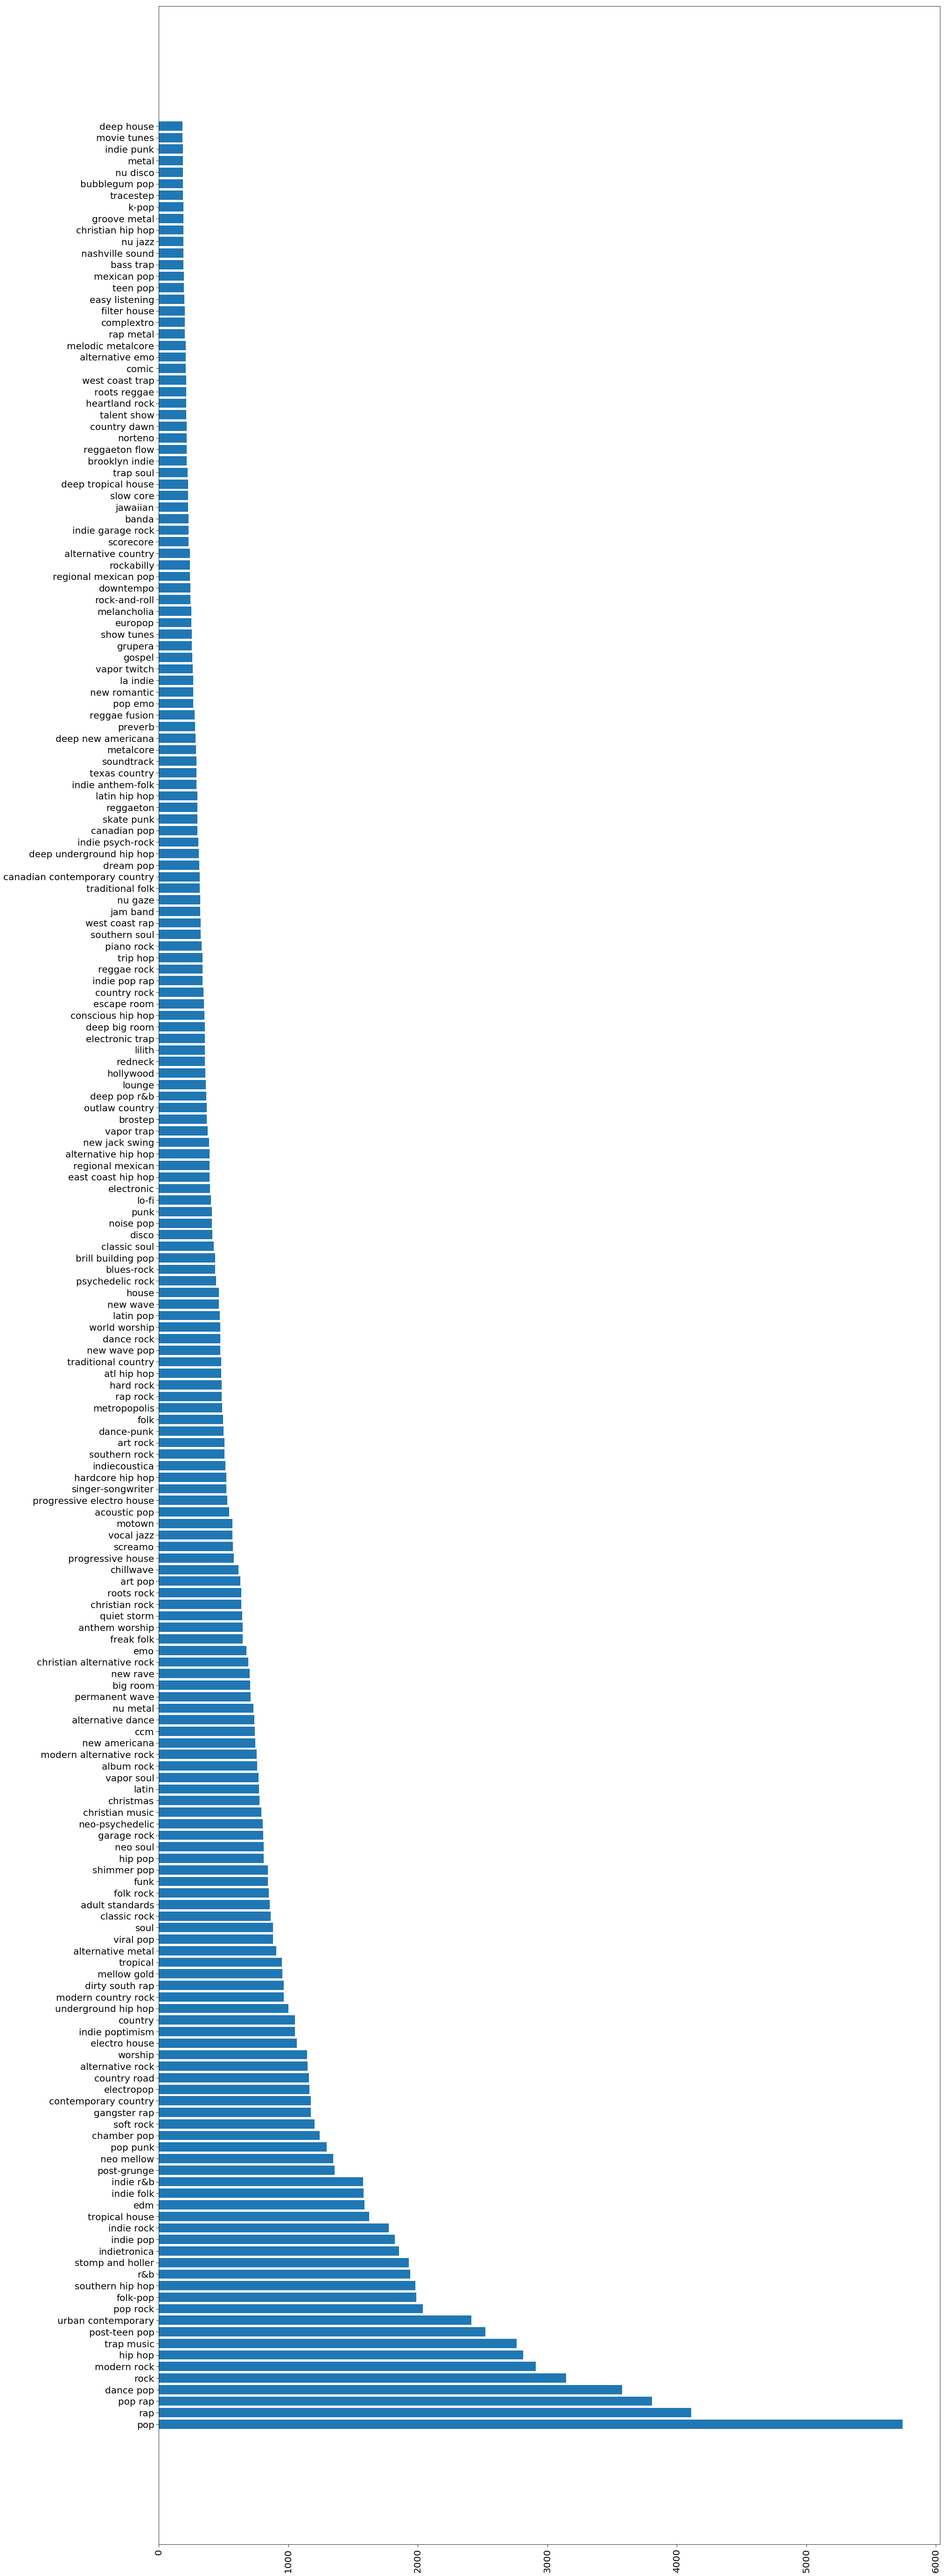

In [33]:
most = genre_counter.most_common(200)

genres = list(zip(*most))[0]
counts = list(zip(*most))[1]
x_pos = np.arange(len(genres)) 


# labels, values = zip(*genre_counter.items())
# indexes = np.arange(len(labels))
fig, ax=plt.subplots(1, 1, figsize=(30,100))
# # plt.
ax.barh(genres, counts)
plt.xticks(rotation=90)

ax.tick_params(labelsize=20, length=6)
# plt.xticks(indexes + width * 0.5, labels)
# ax.show()


Observations are in EDA write-up

## Split train and test data

In [34]:
train_data, test_data = train_test_split(big_data, test_size=0.2, random_state=42)

In [35]:
train_data.shape, test_data.shape

((768, 27), (193, 27))

In [36]:
train_data.head()

collaborative description    duration_ms  modified_at          name  \
481         false         NaN  190448.811531   1508716800  october 2017   
962         false         NaN  147676.566375   1499472000          vero   
570         false         NaN  215787.082353   1410134400     Steampunk   
289         false         NaN  132679.412122   1499990400     Feel good   
113         false         NaN  318520.866230   1452038400      EDM 2015   

     num_albums  num_artists  num_edits  num_followers  num_tracks  \
481          16           13          4              2          17   
962          18           11         13              1          22   
570           8            4          2              1          85   
289          11           11          8              1          11   
113          51           51         45              2          58   

           ...          liveness   loudness      mode  speechiness  \
481        ...          0.135684  15.280552  0.471027     0.085331   
962        ...          0.150326   3.739109  0.380178     0.064393   
570        ...          0.228716  -8.462859  0.423529     0.067889   
289        ...          0.119023  35.303962  0.399462     0.051626   
113        ...          0.200314  -6.350086  0.630945     0.051049   

     time_signature       tempo   valence  year  popularity              genre  
481             3.0   90.404578  0.289508  2016          63                pop  
962             2.0   65.184303  0.372080  2017          57          latin pop  
570             4.0  127.917765  0.621501  2012          14          steampunk  
289             3.0   82.642734  0.284952  1962          52              disco  
113             4.0  118.127354  0.270538  2015           9  progressive house  

[5 rows x 27 columns]

In [37]:
def make_row(track_id, row):
    features = feature_data[track_id]
    for feature in features:
        if feature not in str_feature:
#                     print(feature)
            features[feature] = abs(features[feature] - row[feature])
    popularity = abs(popularity_data[track_id] - row['popularity'])
    features["popularity"] = int(popularity)
    return features

In [38]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
train_data_songs = pd.DataFrame([], columns=columns)
train_data_y = []
train_songs = {}
i = 1
total = train_data.shape[0]
for index, row in train_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index < 10:
            track_id = track["track_uri"].split(':')[-1]
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                train_data_songs = train_data_songs.append(features, ignore_index=True)
                train_data_y.append(1)
    other_keys = get_new_songs(row["genre"], row["year"])
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            train_data_songs = train_data_songs.append(features, ignore_index=True)
            train_data_y.append(0)
    
train_data_songs = train_data_songs.set_index("id")


# remove = ['tracks', "collaborative", "description", "modified_at", "name", "num_edits", "num_followers", "pid"]

# train_data_y = train_data["tracks"]
# train_data_x = train_data[train_data.columns.difference(remove)]
# for index, row in train_data.iterrows():
#     random.shuffle(row["tracks"])
#     train_data_y.append(row["tracks"][-5:])
# #     train_data_x.at[index,"tracks"] = row["tracks"][:-5]

'|##############################| (768/768) with 0 failures'

In [39]:
train_data_songs.head()

acousticness  danceability    energy  \
id                                                             
5KbwfZTcyt5REWi1ZSN4J8      0.256487      0.038074  0.207346   
6m9qPYXmhge2QhBLfFKnVF      0.191067      0.031295  0.207018   
1XcXhu1X0xBFMDFyq0b7Ue      0.228715      0.333826  0.055190   
4dAUGcD3zfZhJPyLXFSAUW      0.197987      0.205074  0.415346   
1V8c3uV6p7uTsfQof5oRXg      0.261201      0.148813  0.185075   

                        instrumentalness       key  liveness   loudness  \
id                                                                        
5KbwfZTcyt5REWi1ZSN4J8          0.044693  2.719462  0.220316  22.180552   
6m9qPYXmhge2QhBLfFKnVF          0.034608  1.220156  0.000507  23.146261   
1XcXhu1X0xBFMDFyq0b7Ue          0.106341  1.989652  0.034016   2.845688   
4dAUGcD3zfZhJPyLXFSAUW          0.044689  4.280538  0.106316  20.024552   
1V8c3uV6p7uTsfQof5oRXg          0.035674  2.119425  0.002675   9.338379   

                            mode  speechiness  time_signature      tempo  \
id                                                                         
5KbwfZTcyt5REWi1ZSN4J8  0.528973     0.189669             1.0  41.683422   
6m9qPYXmhge2QhBLfFKnVF  0.235387     0.003495             1.0   8.267249   
1XcXhu1X0xBFMDFyq0b7Ue  0.304816     0.057926             3.0  48.997931   
4dAUGcD3zfZhJPyLXFSAUW  0.528973     0.100669             1.0  49.607422   
1V8c3uV6p7uTsfQof5oRXg  0.347070     0.064671             0.0  24.243346   

                         valence popularity  \
id                                            
5KbwfZTcyt5REWi1ZSN4J8  0.314492          7   
6m9qPYXmhge2QhBLfFKnVF  0.149160          7   
1XcXhu1X0xBFMDFyq0b7Ue  0.120840          1   
4dAUGcD3zfZhJPyLXFSAUW  0.440492         21   
1V8c3uV6p7uTsfQof5oRXg  0.147535          1   

                                                             analysis_url  \
id                                                                          
5KbwfZTcyt5REWi1ZSN4J8  https://api.spotify.com/v1/audio-analysis/5Kbw...   
6m9qPYXmhge2QhBLfFKnVF  https://api.spotify.com/v1/audio-analysis/6m9q...   
1XcXhu1X0xBFMDFyq0b7Ue  https://api.spotify.com/v1/audio-analysis/1XcX...   
4dAUGcD3zfZhJPyLXFSAUW  https://api.spotify.com/v1/audio-analysis/4dAU...   
1V8c3uV6p7uTsfQof5oRXg  https://api.spotify.com/v1/audio-analysis/1V8c...   

                         duration_ms  \
id                                     
5KbwfZTcyt5REWi1ZSN4J8  41919.188469   
6m9qPYXmhge2QhBLfFKnVF  21082.892632   
1XcXhu1X0xBFMDFyq0b7Ue  77950.531877   
4dAUGcD3zfZhJPyLXFSAUW   1980.188469   
1V8c3uV6p7uTsfQof5oRXg  26227.478690   

                                                               track_href  \
id                                                                          
5KbwfZTcyt5REWi1ZSN4J8  https://api.spotify.com/v1/tracks/5KbwfZTcyt5R...   
6m9qPYXmhge2QhBLfFKnVF  https://api.spotify.com/v1/tracks/6m9qPYXmhge2...   
1XcXhu1X0xBFMDFyq0b7Ue  https://api.spotify.com/v1/tracks/1XcXhu1X0xBF...   
4dAUGcD3zfZhJPyLXFSAUW  https://api.spotify.com/v1/tracks/4dAUGcD3zfZh...   
1V8c3uV6p7uTsfQof5oRXg  https://api.spotify.com/v1/tracks/1V8c3uV6p7uT...   

                                  type                                   uri  
id                                                                            
5KbwfZTcyt5REWi1ZSN4J8  audio_features  spotify:track:5KbwfZTcyt5REWi1ZSN4J8  
6m9qPYXmhge2QhBLfFKnVF  audio_features  spotify:track:6m9qPYXmhge2QhBLfFKnVF  
1XcXhu1X0xBFMDFyq0b7Ue  audio_features  spotify:track:1XcXhu1X0xBFMDFyq0b7Ue  
4dAUGcD3zfZhJPyLXFSAUW  audio_features  spotify:track:4dAUGcD3zfZhJPyLXFSAUW  
1V8c3uV6p7uTsfQof5oRXg  audio_features  spotify:track:1V8c3uV6p7uTsfQof5oRXg

In [40]:
# print(columns)
train_data_songs.dtypes
# train_data_songs[np.array(train_data_y) == 0][["popularity"]].describe()

acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
time_signature      float64
tempo               float64
valence             float64
popularity           object
analysis_url         object
duration_ms         float64
track_href           object
type                 object
uri                  object
dtype: object

In [41]:
train_data_songs["popularity"] = train_data_songs["popularity"].astype("float64")

In [42]:
train_data_songs[np.array(train_data_y) == 1][columns].describe()

acousticness  danceability       energy  instrumentalness          key  \
count   7582.000000   7582.000000  7582.000000       7582.000000  7582.000000   
mean       0.139167      0.190873     0.210611          0.083778     2.273942   
std        0.123849      0.122482     0.134957          0.125773     1.620145   
min        0.000000      0.000000     0.000000          0.000000     0.000000   
25%        0.054554      0.090235     0.097044          0.021738     0.972237   
50%        0.104846      0.177671     0.200303          0.042408     2.054077   
75%        0.182732      0.280191     0.308299          0.081218     3.195611   
max        0.797796      0.663642     0.723317          0.887851     8.345966   

          liveness     loudness         mode  speechiness  time_signature  \
count  7582.000000  7582.000000  7582.000000  7582.000000     7582.000000   
mean      0.081795    13.539674     0.302043     0.044147        1.332498   
std       0.087756    14.247650     0.179072     0.052155        0.908618   
min       0.000000     0.002593     0.000000     0.000000        0.000000   
25%       0.029805     4.299979     0.150750     0.014262        1.000000   
50%       0.063167     9.557040     0.298293     0.030781        1.000000   
75%       0.102986    17.851413     0.442396     0.054490        2.000000   
max       0.811885   218.871737     0.921708     0.806837        4.000000   

             tempo      valence   popularity  
count  7582.000000  7582.000000  7582.000000  
mean     38.296317     0.172306    15.689264  
std      25.154283     0.121383    13.313337  
min       0.000000     0.000000     0.000000  
25%      17.450566     0.074202     5.000000  
50%      35.298071     0.154670    12.000000  
75%      56.193799     0.246405    23.000000  
max     133.466159     0.682806    73.000000

In [43]:
train_data_songs[np.array(train_data_y) == 0][columns].describe()

acousticness  danceability        energy  instrumentalness  \
count  33319.000000  33319.000000  33319.000000      33319.000000   
mean       0.132116      0.204044      0.226331          0.068211   
std        0.122057      0.128371      0.143916          0.100495   
min        0.000008      0.000004      0.000016          0.000002   
25%        0.049965      0.096343      0.106108          0.017793   
50%        0.099166      0.194597      0.216535          0.037673   
75%        0.171354      0.297803      0.328945          0.071539   
max        0.930804      0.728112      0.878278          0.922308   

                key      liveness      loudness          mode   speechiness  \
count  33319.000000  3.331900e+04  33319.000000  33319.000000  33319.000000   
mean       2.139174  7.883331e-02     14.446585      0.278321      0.042253   
std        1.459218  7.167231e-02     15.334438      0.176247      0.040816   
min        0.000000  5.822389e-07      0.000589      0.000026      0.000001   
25%        0.982677  3.293997e-02      4.611207      0.131570      0.016123   
50%        1.984651  6.849234e-02     10.398370      0.266740      0.033479   
75%        3.005516  1.047921e-01     18.965707      0.405063      0.055365   
max        8.435243  8.946976e-01    211.085408      0.951807      0.809849   

       time_signature         tempo       valence    popularity  
count    33319.000000  33319.000000  33319.000000  33319.000000  
mean         1.320208     40.705937      0.179970     16.625709  
std          0.947615     26.238988      0.121718     11.388001  
min          0.000000      0.000629      0.000001      0.000000  
25%          1.000000     19.130776      0.082467      8.000000  
50%          1.000000     37.998450      0.167336     15.000000  
75%          2.000000     59.377854      0.255839     23.000000  
max          4.000000    145.927450      0.801833     68.000000

[0.13916745224960686, 0.19087324538056105, 0.2106114565940626, 0.08377827183922984, 2.2739415835208754, 0.08179531230634066, 13.539674378366051, 0.3020426766196375, 0.04414655959603667, 1.3324980216301767, 0.17230592110435392, 15.689264046425745]
[0.1321158626479472, 0.20404355366092133, 0.2263308193832485, 0.06821114335271385, 2.1391737041024865, 0.0788333144819929, 14.446584648182892, 0.27832057297223006, 0.0422527999443698, 1.3202076893064016, 0.17997021089688506, 16.625709054893605]


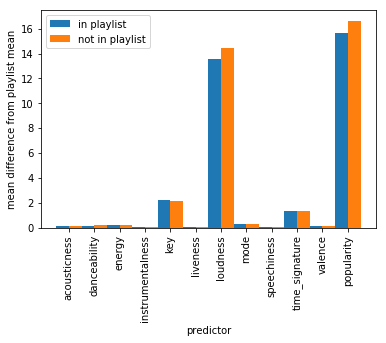

In [44]:
# we don't plot tempo b/c it's off the charts
pltcols=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
         "valence", "popularity"]
xs = np.arange((len(pltcols))) - 0.25
inplaylist = []
notinplaylist = []
for col in pltcols:
    if col != "tempo":
        d = train_data_songs[col]
        inplaylist.append(np.mean(d[np.array(train_data_y) == 1]))
        notinplaylist.append(np.mean(d[np.array(train_data_y) == 0]))
    
print(inplaylist)
print(notinplaylist)

    
plt.bar(xs, inplaylist, align='center', width=0.5, label="in playlist")
plt.bar(xs + 0.5, notinplaylist, align='center', width=0.5, label="not in playlist")
plt.xlabel("predictor")
plt.ylabel("mean difference from playlist mean")
plt.xticks([r for r in range(len(pltcols))], pltcols, rotation=90)
plt.legend()
# for col in train_data_songs.co

In [45]:
train_data_x = train_data_songs[columns]
train_data_x.head()

acousticness  danceability    energy  \
id                                                             
5KbwfZTcyt5REWi1ZSN4J8      0.256487      0.038074  0.207346   
6m9qPYXmhge2QhBLfFKnVF      0.191067      0.031295  0.207018   
1XcXhu1X0xBFMDFyq0b7Ue      0.228715      0.333826  0.055190   
4dAUGcD3zfZhJPyLXFSAUW      0.197987      0.205074  0.415346   
1V8c3uV6p7uTsfQof5oRXg      0.261201      0.148813  0.185075   

                        instrumentalness       key  liveness   loudness  \
id                                                                        
5KbwfZTcyt5REWi1ZSN4J8          0.044693  2.719462  0.220316  22.180552   
6m9qPYXmhge2QhBLfFKnVF          0.034608  1.220156  0.000507  23.146261   
1XcXhu1X0xBFMDFyq0b7Ue          0.106341  1.989652  0.034016   2.845688   
4dAUGcD3zfZhJPyLXFSAUW          0.044689  4.280538  0.106316  20.024552   
1V8c3uV6p7uTsfQof5oRXg          0.035674  2.119425  0.002675   9.338379   

                            mode  speechiness  time_signature      tempo  \
id                                                                         
5KbwfZTcyt5REWi1ZSN4J8  0.528973     0.189669             1.0  41.683422   
6m9qPYXmhge2QhBLfFKnVF  0.235387     0.003495             1.0   8.267249   
1XcXhu1X0xBFMDFyq0b7Ue  0.304816     0.057926             3.0  48.997931   
4dAUGcD3zfZhJPyLXFSAUW  0.528973     0.100669             1.0  49.607422   
1V8c3uV6p7uTsfQof5oRXg  0.347070     0.064671             0.0  24.243346   

                         valence  popularity  
id                                            
5KbwfZTcyt5REWi1ZSN4J8  0.314492         7.0  
6m9qPYXmhge2QhBLfFKnVF  0.149160         7.0  
1XcXhu1X0xBFMDFyq0b7Ue  0.120840         1.0  
4dAUGcD3zfZhJPyLXFSAUW  0.440492        21.0  
1V8c3uV6p7uTsfQof5oRXg  0.147535         1.0

In [46]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
test_data_songs = pd.DataFrame([], columns=columns)
test_data_y = []
test_songs = {}
i = 1
total = test_data.shape[0]
for index, row in test_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index < 10:
            track_id = track["track_uri"].split(':')[-1]
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                test_data_songs = test_data_songs.append(features, ignore_index=True)
                test_data_y.append(1)
#     other_keys = random.sample(song_keys, 30)
    other_keys = get_new_songs(row["genre"], row["year"])
    songs = []
    for key in other_keys:
#         if not key in tracks:
#             if not key in feature_data:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            test_data_songs = test_data_songs.append(features, ignore_index=True)
            test_data_y.append(0)
#         else:
#             new_songs.append(key)
            
test_data_songs = test_data_songs.set_index("id")
test_data_x = test_data_songs[columns]
train_data_x.head()

'|##############################| (193/193) with 0 failures'

acousticness  danceability    energy  \
id                                                             
5KbwfZTcyt5REWi1ZSN4J8      0.256487      0.038074  0.207346   
6m9qPYXmhge2QhBLfFKnVF      0.191067      0.031295  0.207018   
1XcXhu1X0xBFMDFyq0b7Ue      0.228715      0.333826  0.055190   
4dAUGcD3zfZhJPyLXFSAUW      0.197987      0.205074  0.415346   
1V8c3uV6p7uTsfQof5oRXg      0.261201      0.148813  0.185075   

                        instrumentalness       key  liveness   loudness  \
id                                                                        
5KbwfZTcyt5REWi1ZSN4J8          0.044693  2.719462  0.220316  22.180552   
6m9qPYXmhge2QhBLfFKnVF          0.034608  1.220156  0.000507  23.146261   
1XcXhu1X0xBFMDFyq0b7Ue          0.106341  1.989652  0.034016   2.845688   
4dAUGcD3zfZhJPyLXFSAUW          0.044689  4.280538  0.106316  20.024552   
1V8c3uV6p7uTsfQof5oRXg          0.035674  2.119425  0.002675   9.338379   

                            mode  speechiness  time_signature      tempo  \
id                                                                         
5KbwfZTcyt5REWi1ZSN4J8  0.528973     0.189669             1.0  41.683422   
6m9qPYXmhge2QhBLfFKnVF  0.235387     0.003495             1.0   8.267249   
1XcXhu1X0xBFMDFyq0b7Ue  0.304816     0.057926             3.0  48.997931   
4dAUGcD3zfZhJPyLXFSAUW  0.528973     0.100669             1.0  49.607422   
1V8c3uV6p7uTsfQof5oRXg  0.347070     0.064671             0.0  24.243346   

                         valence  popularity  
id                                            
5KbwfZTcyt5REWi1ZSN4J8  0.314492         7.0  
6m9qPYXmhge2QhBLfFKnVF  0.149160         7.0  
1XcXhu1X0xBFMDFyq0b7Ue  0.120840         1.0  
4dAUGcD3zfZhJPyLXFSAUW  0.440492        21.0  
1V8c3uV6p7uTsfQof5oRXg  0.147535         1.0

## Building the Model

Model ideas: Find similar songs to all the songs in the playlist using Last.fm. Then do some sort of classification to determine whether we want to add them to our playlist using some parameters and then continue. Alternatively, pick the best songs, then classify their similar. **Use a neural network**

*This might be making the problem too easy, so maybe we select 1000 songs from the Genre or something and classify them*

https://www.last.fm/api

TODO: Pick parameters to optimize prediction

- Get other songs by the same artist
- Get songs same genre time period

- Split a playlist in 3/4 (1/4 for response)
- "Train" it to predict the response songs

- Most common genre and time period
- Search spotify and get 200 songs
- Run that through Neural Network

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
logreg = LogisticRegression(C=10000, solver='newton-cg', max_iter=250)
logreg.fit(train_data_x, train_data_y)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
coefs = zip(train_data_x.columns, logreg.coef_[0])
# print(list(coefs))
# print(logreg.coef_)
# print(train_data_x.columns)
# logreg.coef_

In [50]:
logreg.score(test_data_x, test_data_y)

0.8168473568070613

In [94]:
p = logreg.predict(test_data_x)
print(sum(p))

1


In [51]:
limit = 5
lastfmkey = "b4c63b3d7fb0c8d3ed670d8d78d737df"
def get_song_similar(song, artist):
    data = {'api_key': lastfmkey, 'artist': artist, 'track': song, 'limit': limit}
    response = requests.get('http://ws.audioscrobbler.com/2.0/?method=track.getsimilar&format=json', data=data)
    pp.pprint(response.content)

# Let's Try It!
We'll give our model a country playlist and ask it to select songs

In [59]:
def getPlaylistSongs(id):
    url = base_url + '/playlists/' + id
    r =requests.get(url, headers=headers)
    data = r.json()
    return data['tracks']['items']

In [60]:
def getSongs(songs):
    url = base_url + '/tracks'
    i = 0
    payload = {'ids': ','.join(songs)}
    r =requests.get(url, headers=headers, params=payload)
    data = r.json()
    names = []
    for track in data['tracks']:
        names.append(track['name'])
    return names

In [97]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

def predictSongs(playlist_id):
    tracks = getPlaylistSongs(myplaylist)
    if tracks:
        features = {
            "acousticness": 0,
            "danceability": 0,
            "duration_ms" : 0,
            "energy" : 0,
            "instrumentalness" : 0,
            "key" : 0,
            "liveness" : 0,
            "loudness" : 0,
            "mode" : 0,
            "speechiness" : 0,
            "time_signature" : 0,
            "tempo" : 0,
            "valence" : 0,
        }
        albums = set({})
        years = set({})
        ids = set({})
        new_songs = pd.DataFrame([], columns=columns)
        songs = []
        seen = []
        for song in tracks:
            song_id = (song['track']['id'])
            ids.add(song_id)
            if song_id in feature_data:
                seen.append(song_id)
            else:
                songs.append(song_id)
                artist_id = song['track']['album']['artists'][0]['id']
                album_id = song['track']['album']['id']
                albums.add(album_id)
                artists.add(artist_id)
        try:
            song_features = get_features(songs)
            genres, genre_list = get_genres(list(artists))
            years, years_list = get_years(list(albums))
            popularity = get_popularity(songs)
            popularity_list = list(popularity)
            for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
                feature_data[song] = feature
                genre_data[song] = genre
                year_data[song] = year
                popularity_data[song] = pop
            # add data from our seen songs
            for song in seen:
                print('song')
                song_features.append(feature_data[song])
    #             temp = ''
    #             for genre in genre_data[song]:
    #                 if len(genre) == 1:
    #                     print(genre)
                if type(genre_data[song]) == list:
                    for genre in genre_data[song]:
                        genres[genre] += 1
                else:
    #                 print(genre_data[song])
                    genres[genre_data[song]] += 1
                popularity.append(popularity_data[song])
                years[year_data[song]] += 1
            print('here')
            # update popularity to be median value (not mean b/c outliers)
            popularity = np.median(popularity)
            features['popularity'] = popularity        

            # insert all information into features dict
            for song in song_features:
                for feature in all_features:
                    features[feature] += song[feature]
            print('there')
            # average necessary values and update data table
            for feature in feature_names:
                if feature in all_features:
                    features[feature] = features[feature] / len(tracks)
                    if feature == "time_signature":
                        features[feature] = int(features[feature] + 0.5)
                elif feature == "year":
                    features["year"] = int(years.most_common(1)[0][0])
                elif feature == "genre":
                    features["genre"] = genres.most_common(1)[0][0]
#                     print("genre", genres)
#             print(features)
            # predict on new songs
#             id_set = set(ids)
            random_songs = get_new_songs(row["genre"], row["year"])
            sample_songs = pd.DataFrame([], columns=columns)
            print('everywhere')
            for key in random_songs:
                if not key in ids and key in feature_data:
                    stats = make_row(key, features)
                    sample_songs = sample_songs.append(stats, ignore_index=True)
#             print(sample_songs[columns])
#             print('here')
            print('x')
#             print(sample_songs[columns])
            predictions = logreg.predict(sample_songs[columns])
#             print(predictions)
            predicted_songs = []
            for i in range(len(predictions)):
                if predictions[i] == 1:
                    predicted_songs.append(random_songs[i])
            print('y')
            print(predicted_songs)
            if(len(predicted_songs) > 50):
                predicted_songs = predicted_songs[:50]
            elif(len(predicted_songs) == 0):
                print('No songs could be found')
                return(None)
            song_names = getSongs(predicted_songs)
            return song_names
        except Exception as ex:
            print('error', ex)
    else:
        print("Playlist cannot be found. Make sure it's not private!")

In [98]:
myplaylist = '4IRSXGb7jV2U8j06ToX1yz'
myplaylistfeatures = predictSongs(myplaylist)

song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
here
there
everywhere
x
y
[]
No songs could be found


In [58]:
myplaylistfeatures

In [57]:
features

{'danceability': 0.3121020884482248,
 'energy': 0.3472002299501096,
 'key': 2.9910431396139274,
 'loudness': 11.630411945983308,
 'mode': 0.07468786224232937,
 'speechiness': 0.002112406006279363,
 'acousticness': 0.03307827511407879,
 'instrumentalness': 0.00058387312651767,
 'liveness': 0.07036311792770386,
 'valence': 0.24893323914560056,
 'tempo': 62.556071248511245,
 'type': 'audio_features',
 'id': '5UsW4W8VgHrRLDzXQ9XSpt',
 'uri': 'spotify:track:5UsW4W8VgHrRLDzXQ9XSpt',
 'track_href': 'https://api.spotify.com/v1/tracks/5UsW4W8VgHrRLDzXQ9XSpt',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5UsW4W8VgHrRLDzXQ9XSpt',
 'duration_ms': 125382.46389176826,
 'time_signature': 1.0,
 'popularity': 5}